In [1]:
from astropy.io import fits
from matplotlib import pyplot as plt
import numpy as np

# matplotlib configuration
plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.autolayout'] = True
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['figure.figsize'] = (3.27, 2)
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['axes.titlesize'] = 12
plt.rcParams['lines.linewidth'] = 1
plt.rcParams['axes.linewidth'] = 1
plt.rcParams['legend.fontsize'] = 10
plt.rcParams["savefig.bbox"] = 'tight'
plt.rcParams['savefig.pad_inches'] = 0.3
plt.rcParams['font.family'] = 'Fira Code'
plt.rcParams['mathtext.fontset'] = 'custom'
plt.rcParams['mathtext.rm'] = 'Fira Code'
plt.rcParams['mathtext.it'] = 'Fira Code'
plt.ioff()

In [2]:
def open_mozaïek(mozaïek) -> fits.HDUList:
  path = f"/home/raulwolters/Downloads/CGPS_DataCubes/CGPS_{mozaïek}_HI_line_image.fits"
  return fits.open(path)

hdus_M1 = open_mozaïek("MM1")
hdus_M2 = open_mozaïek("MM2")
hdus_N1 = open_mozaïek("MN1")
hdus_N2 = open_mozaïek("MN2")
hdus_O1 = open_mozaïek("MO1")
hdus_O2 = open_mozaïek("MO2")

In [3]:
REF_PX = 513 #reference px for location of image
PX_SIZE = 5e-3 #angular px size

#positions of the data cubes
POS_N1 = np.array([80.75, -1])
POS_N2 = np.array([80.75, 3])
POS_O1 = np.array([76.75, -1])
POS_O2 = np.array([76.75, 3])

delta_px_lat = (POS_N1 - POS_N2) / PX_SIZE
delta_px_long = (POS_O1 - POS_N1) / PX_SIZE

print(delta_px_lat, delta_px_long)

[   0. -800.] [-800.    0.]


In [4]:
#combineer de images
dpx = -int(delta_px_lat[1])
dpy = -int(delta_px_long[0])
img_size = 1024
canvas = np.zeros((272, img_size + dpy, img_size + (2*dpy)))

#y posities
m_start_y = 0
m_end_y = img_size
n_start_y = m_start_y + dpy
n_end_y = m_end_y + dpy
o_start_y = n_start_y + dpy
o_end_y = n_end_y + dpy

print(m_start_y, m_end_y, n_start_y, n_end_y, o_start_y, o_end_y)

#plot m1 aan linker kant
start_x1 = 0
end_x1 = 1024
canvas[:,start_x1:end_x1, m_start_y:m_end_y] = hdus_M1[0].data[0, :, :, :]

#plot m2 aan rechter kant
start_x2 = start_x1 - int(delta_px_lat[1])
end_x2 = end_x1 - int(delta_px_lat[1])
canvas[:, start_x2:end_x2, m_start_y:m_end_y] = hdus_M2[0].data[0, :, :, :]

#plot n1
canvas[:,start_x1:end_x1, n_start_y:n_end_y] = hdus_N1[0].data[0, :, :, :]

#plot n2
canvas[:, start_x2:end_x2, n_start_y:n_end_y] = hdus_N2[0].data[0, :, :, :]

#plot o1 rechtsboven
canvas[:,start_x1:end_x1, o_start_y:o_end_y] = hdus_O1[0].data[0, :, :, :]

#plot 02 rechtsonder
canvas[:,start_x2:end_x2, o_start_y:o_end_y] = hdus_O2[0].data[0, :, :, :]

0 1024 800 1824 1600 2624


In [5]:
x_start, x_stop = 500, 1500
y_start, y_stop = 0, 2250

plt.figure(figsize=(8, 8), dpi=80)
plt.imshow(canvas[130, x_start:x_stop, y_start:y_stop])
plt.figure(figsize=(8, 8), dpi=80)
plt.imshow(canvas[200, x_start:x_stop, y_start:y_stop])

#delete the old canvas
plane = canvas[:, x_start:x_stop, y_start:y_stop]
del canvas

In [6]:
#normalise all slices
for index in range(0, plane.shape[0]):
  slice = plane[index, :, :]
  if slice.shape != (1000, 2250): print(slice.shape)
  slice_avg = np.nanmean(slice)
  plane[index] = (slice - slice_avg) / slice_avg

/tmp/ipykernel_20259/3704276110.py:5: RuntimeWarning: Mean of empty slice
  slice_avg = np.nanmean(slice)


In [7]:
plt.imshow(plane[130])
plt.colorbar()
plt.figure()
plt.imshow(plane[200])
plt.colorbar()

In [8]:
def ellipse(canvas, a, b, fill=0):
  mid = np.array(canvas.shape) // 2
  
  #draw ellipse around the middle
  for i, col in enumerate(canvas):
    for j, item in enumerate(col):
      d = np.sqrt(
        ((mid[0] - i)/a)**2 + 
        ((mid[1] - j)/b)**2
      )
      if d < 1: canvas[i,j] = fill

def filter(fourier, lower_bound, upper_bound, low_pass=False):
  #we start with an empty canvas
  if low_pass: filter = np.zeros(fourier.shape)
  else: filter = np.ones(fourier.shape)
  
  if low_pass: fill, anti_fill = 1, 0
  else: fill, anti_fill = 0, 1
  
  #then draw a large ellipse for the upper bound
  a = upper_bound
  b = (a * filter.shape[1]) / filter.shape[0]
  ellipse(filter, a, b, fill=fill)
  
  #and then draw a small ellipse for the lower bound
  a = lower_bound
  b = (a * filter.shape[1]) / filter.shape[0]
  ellipse(filter, a, b, fill=anti_fill)
  
  #plot filter
  plt.figure(figsize=(8, 8), dpi=80)
  plt.imshow(filter)
  plt.title("windowed filter")
  plt.show()
  
  return fourier * filter

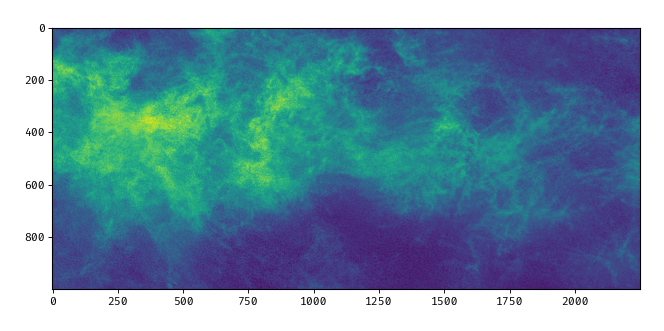

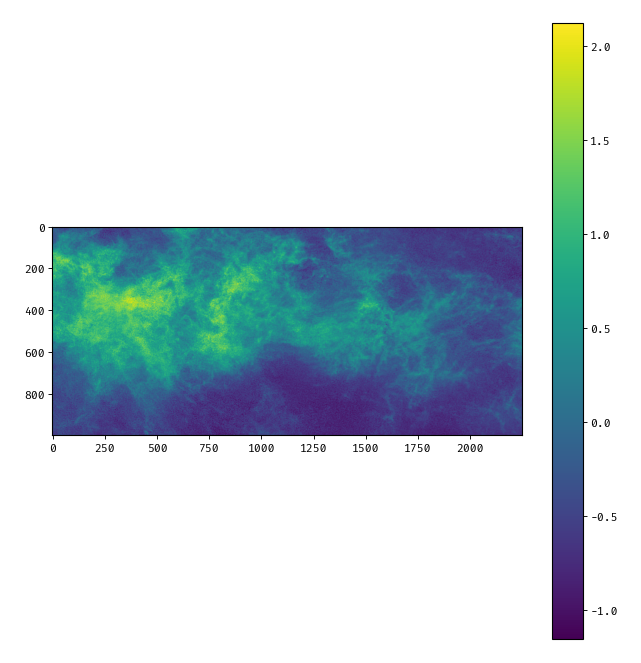

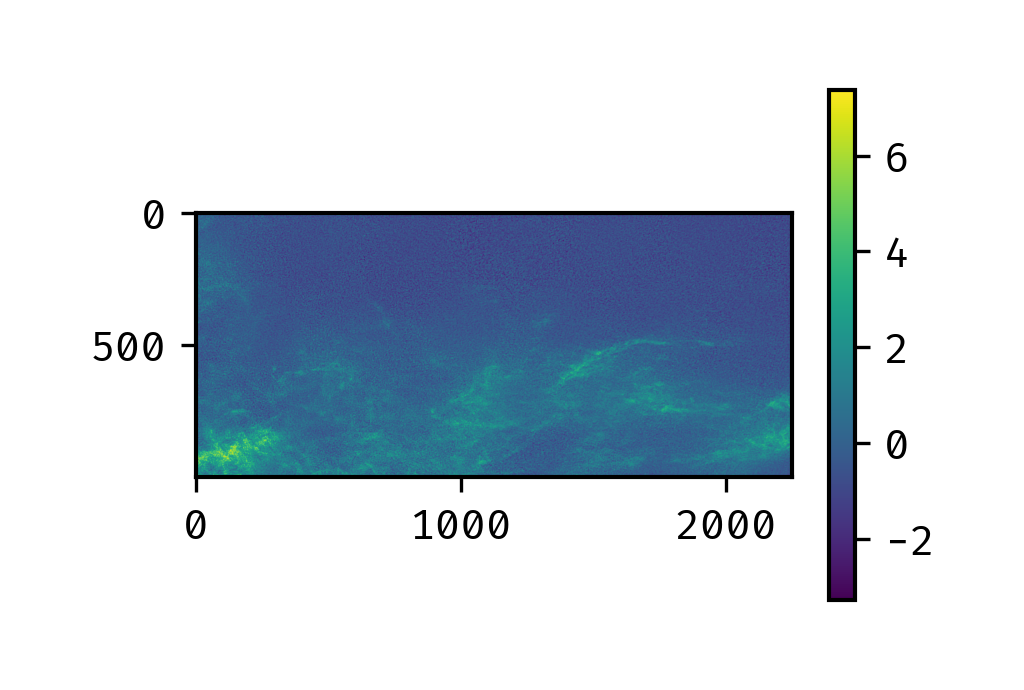

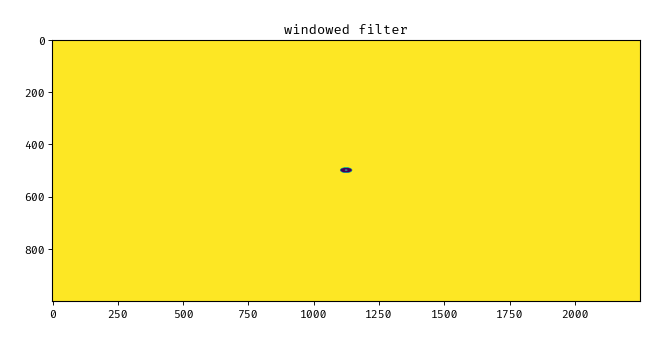

/tmp/ipykernel_20259/616578430.py:8: RuntimeWarning: divide by zero encountered in long_scalars
  ((mid[0] - i)/a)**2 +
/tmp/ipykernel_20259/616578430.py:9: RuntimeWarning: divide by zero encountered in divide
  ((mid[1] - j)/b)**2
/tmp/ipykernel_20259/616578430.py:9: RuntimeWarning: invalid value encountered in divide
  ((mid[1] - j)/b)**2
/tmp/ipykernel_20259/616578430.py:8: RuntimeWarning: invalid value encountered in long_scalars
  ((mid[0] - i)/a)**2 +


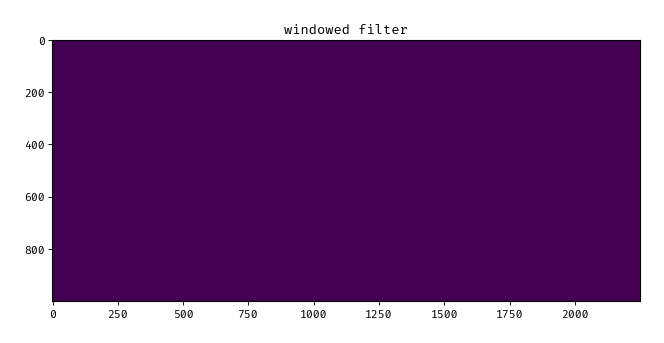

In [9]:
img = plane[200, :, :]
scale = 10

f_img = np.fft.fft2(img)
f_img = np.fft.fftshift(f_img)
f_filter_img = filter(f_img, 2, 10)
f_anti_filter_img = filter(f_img, 2, 0, True)
filter_img = np.fft.ifft2(np.fft.ifftshift(f_filter_img))
anti_filter_img = np.fft.ifft2(np.fft.ifftshift(f_anti_filter_img))

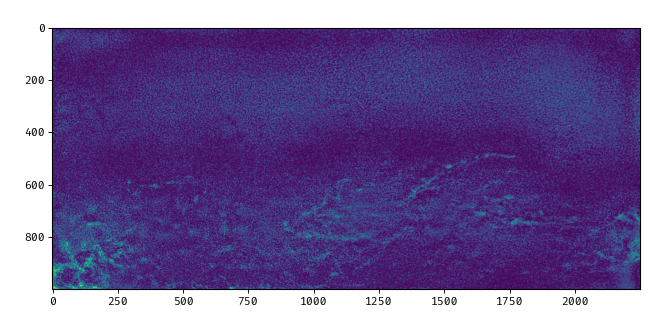

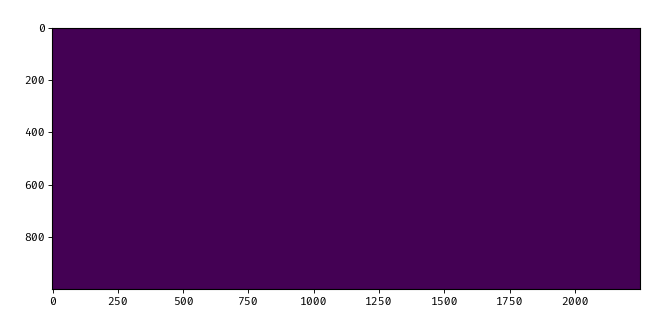

In [10]:
plt.figure(figsize=(8, 8), dpi=80)
plt.imshow(abs(filter_img))
plt.show()

plt.figure(figsize=(8, 8), dpi=80)
plt.imshow(abs(anti_filter_img))
plt.show()